In [178]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, train_test_split
import numpy as np
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalanceCascade, EasyEnsemble
from sklearn.ensemble import AdaBoostClassifier
import warnings
##from itable import PrettyTable, TableStyle, CellStyle
import pandas as pd
warnings.filterwarnings('ignore')
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [183]:
# Generate data with two classes
X, y = make_classification(class_sep=1.2, weights=[0.1, 0.9], n_informative=3,
n_redundant=1, n_features=5, n_clusters_per_class=1,
n_samples=10000, flip_y=0, random_state=10)
pca = PCA(n_components=2)
X = pca.fit_transform(X)
y = y.astype('str')
y[y=='1'] ='L'
y[y=='0'] ='S'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
random_state=0)
X_1, X_2 = X_train[y_train=='S'], X_train[y_train=='L']

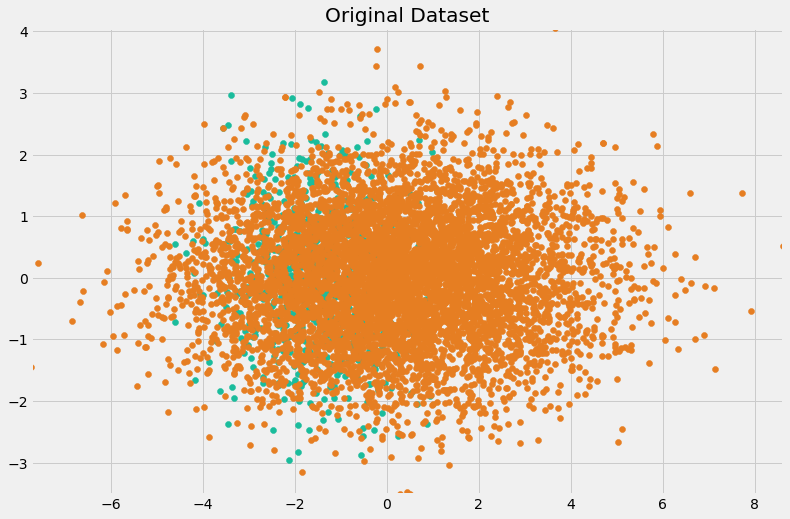

In [184]:
# Scatter plot of the data
plt.scatter(list(zip(*X_1))[0], list(zip(*X_1))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2))[0], list(zip(*X_2))[1], color='#e67e22')
x_coords = list(zip(*X_1))[0] + list(zip(*X_2))[0]
y_coords = list(zip(*X_1))[1] + list(zip(*X_2))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("Original Dataset")
plt.show()

In [142]:
# Fit a Logistic Regression model
clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
'penalty': ['l1', 'l2']}
cv = KFold(X_train.shape[0], shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=-1, scoring='f1_macro')
clf.fit(X_train, y_train)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

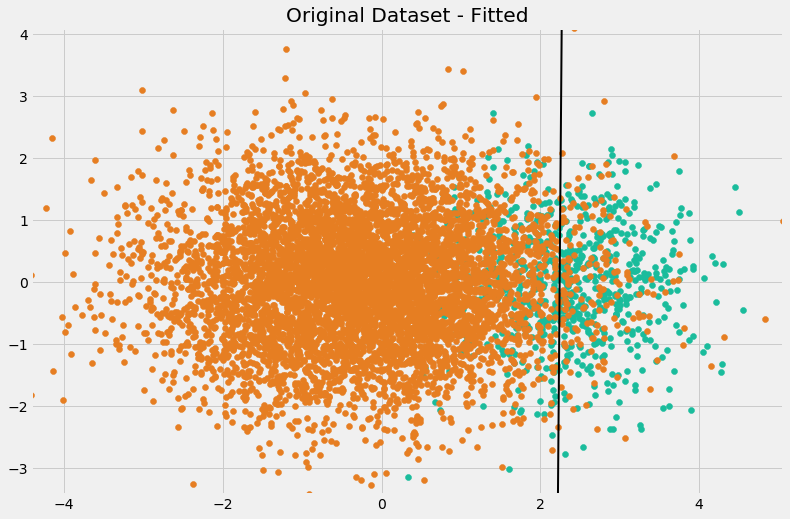

<Figure size 720x1080 with 0 Axes>

In [143]:
# Scatter plot of the data
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

plt.scatter(list(zip(*X_1))[0], list(zip(*X_1))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2))[0], list(zip(*X_2))[1], color='#e67e22')

x_coords = list(zip(*X_1))[0] + list(zip(*X_2))[0]
y_coords = list(zip(*X_1))[1] + list(zip(*X_2))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("Original Dataset - Fitted")
plt.plot(x1, x2, color='black', linewidth=2)
plt.figure(figsize=(10,15))
plt.show()

In [144]:
print (classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           L       0.95      0.98      0.97      2706
           S       0.73      0.55      0.63       294

   micro avg       0.94      0.94      0.94      3000
   macro avg       0.84      0.76      0.80      3000
weighted avg       0.93      0.94      0.93      3000



In [145]:
# Logistic Regression with balanced class weights
clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
'penalty': ['l1', 'l2'],
'class_weight': ['balanced']}
cv = KFold(X_train.shape[0], shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=-1, scoring='f1_macro')
clf.fit(X_train, y_train)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

In [146]:
clf.best_params_

{'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2'}

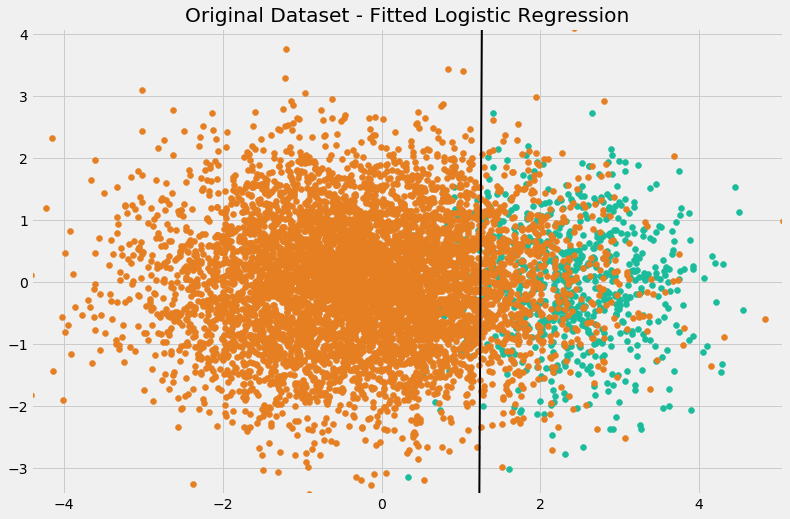

In [147]:
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

plt.scatter(list(zip(*X_1))[0], list(zip(*X_1))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2))[0], list(zip(*X_2))[1], color='#e67e22')

x_coords = list(zip(*X_1))[0] + list(zip(*X_2))[0]
y_coords = list(zip(*X_1))[1] + list(zip(*X_2))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("Original Dataset - Fitted Logistic Regression")
plt.plot(x1, x2, color='black', linewidth=2)
plt.show()

In [148]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           L       0.99      0.88      0.93      2706
           S       0.45      0.88      0.60       294

   micro avg       0.88      0.88      0.88      3000
   macro avg       0.72      0.88      0.77      3000
weighted avg       0.93      0.88      0.90      3000



In [149]:
# Random undersampling of majority class
us = RandomUnderSampler(ratio=0.5, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))
clf_base = LogisticRegression(C=1)
grid = {
'penalty': ['l1']}
cv = KFold(X_train_res.shape[0], shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
clf.fit(X_train_res, y_train_res)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]
X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6294, 'S': 706})
Distribution of class labels after resampling Counter({'L': 1412, 'S': 706})


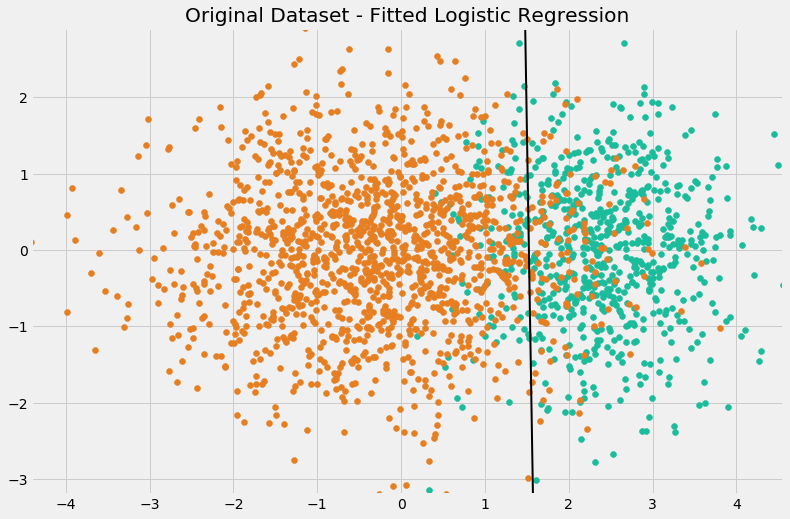

In [150]:
plt.scatter(list(zip(*X_1_res))[0], list(zip(*X_1_res))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2_res))[0], list(zip(*X_2_res))[1], color='#e67e22')

x_coords = list(zip(*X_1_res))[0] + list(zip(*X_2_res))[0]
y_coords = list(zip(*X_1_res))[1] + list(zip(*X_2_res))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("Random UnderSampling")
plt.plot(x1, x2, color='black', linewidth=2)
plt.show()

In [151]:
print (classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           L       0.98      0.92      0.95      2706
           S       0.54      0.82      0.65       294

   micro avg       0.91      0.91      0.91      3000
   macro avg       0.76      0.87      0.80      3000
weighted avg       0.94      0.91      0.92      3000



In [152]:
us = NearMiss(ratio=0.5, n_neighbors=3, version=1, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))
clf_base = LogisticRegression(C=1)
grid = {'penalty': ['l1']}
cv = KFold(X_train_res.shape[0], shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
clf.fit(X_train_res, y_train_res)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]
X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6294, 'S': 706})
Distribution of class labels after resampling Counter({'L': 1412, 'S': 706})


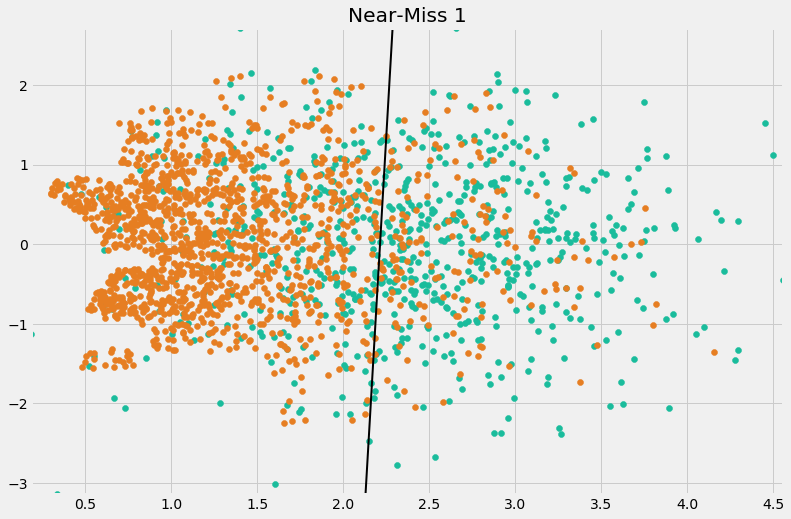

In [153]:
plt.scatter(list(zip(*X_1_res))[0], list(zip(*X_1_res))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2_res))[0], list(zip(*X_2_res))[1], color='#e67e22')

x_coords = list(zip(*X_1_res))[0] + list(zip(*X_2_res))[0]
y_coords = list(zip(*X_1_res))[1] + list(zip(*X_2_res))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("Near-Miss 1")
plt.plot(x1, x2, color='black', linewidth=2)
plt.show()

In [154]:
print (classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           L       0.95      0.98      0.97      2706
           S       0.73      0.56      0.64       294

   micro avg       0.94      0.94      0.94      3000
   macro avg       0.84      0.77      0.80      3000
weighted avg       0.93      0.94      0.93      3000



In [155]:
us = NearMiss(ratio=0.5, n_neighbors=3, version=2, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))
clf_base = LogisticRegression()
grid = {'penalty': ['l1', 'l2']}
cv = KFold(X_train_res.shape[0], shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
clf.fit(X_train_res, y_train_res)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]
X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6294, 'S': 706})
Distribution of class labels after resampling Counter({'L': 1412, 'S': 706})


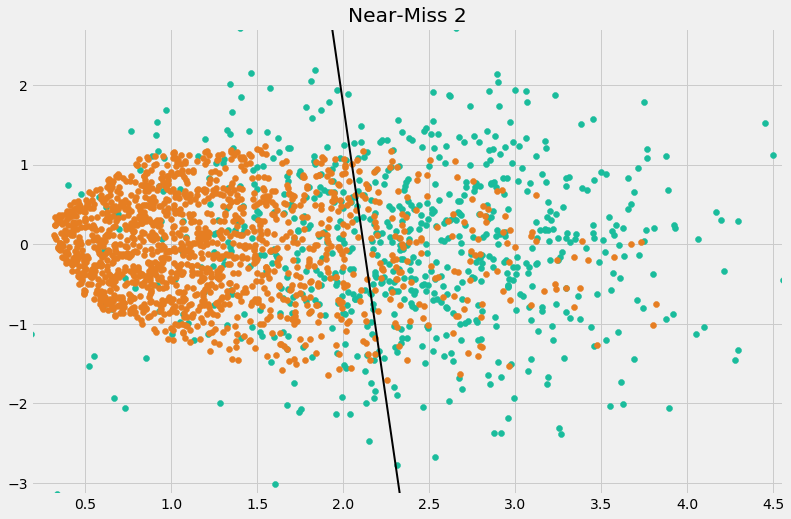

In [156]:
plt.scatter(list(zip(*X_1_res))[0], list(zip(*X_1_res))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2_res))[0], list(zip(*X_2_res))[1], color='#e67e22')

x_coords = list(zip(*X_1_res))[0] + list(zip(*X_2_res))[0]
y_coords = list(zip(*X_1_res))[1] + list(zip(*X_2_res))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("Near-Miss 2")
plt.plot(x1, x2, color='black', linewidth=2)
plt.show()

In [157]:
print (classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           L       0.96      0.97      0.97      2706
           S       0.72      0.61      0.66       294

   micro avg       0.94      0.94      0.94      3000
   macro avg       0.84      0.79      0.81      3000
weighted avg       0.94      0.94      0.94      3000



In [158]:
# Near Miss 3
us = NearMiss(ratio=0.5, n_neighbors=3, n_neighbors_ver3=3, version=3, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))
clf_base = LogisticRegression()
grid = {'penalty': ['l1', 'l2']}
cv = KFold(X_train_res.shape[0], shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
clf.fit(X_train_res, y_train_res)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]
X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6294, 'S': 706})
Distribution of class labels after resampling Counter({'S': 706, 'L': 688})


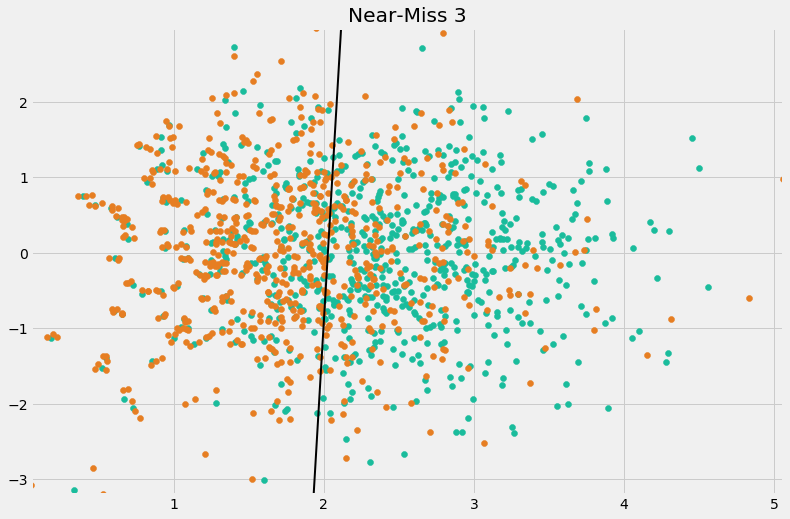

In [159]:
plt.scatter(list(zip(*X_1_res))[0], list(zip(*X_1_res))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2_res))[0], list(zip(*X_2_res))[1], color='#e67e22')

x_coords = list(zip(*X_1_res))[0] + list(zip(*X_2_res))[0]
y_coords = list(zip(*X_1_res))[1] + list(zip(*X_2_res))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("Near-Miss 3")
plt.plot(x1, x2, color='black', linewidth=2)
plt.show()

In [160]:
print (classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           L       0.96      0.97      0.97      2706
           S       0.72      0.65      0.69       294

   micro avg       0.94      0.94      0.94      3000
   macro avg       0.84      0.81      0.83      3000
weighted avg       0.94      0.94      0.94      3000



In [161]:
# Edited Nearest Neighbor (ENN)
us = EditedNearestNeighbours(n_neighbors=5, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))
clf_base = LogisticRegression()
grid = {'penalty': ['l1', 'l2']}
cv = KFold(X_train_res.shape[0], shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
clf.fit(X_train_res, y_train_res)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]
X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6294, 'S': 706})
Distribution of class labels after resampling Counter({'L': 5489, 'S': 706})


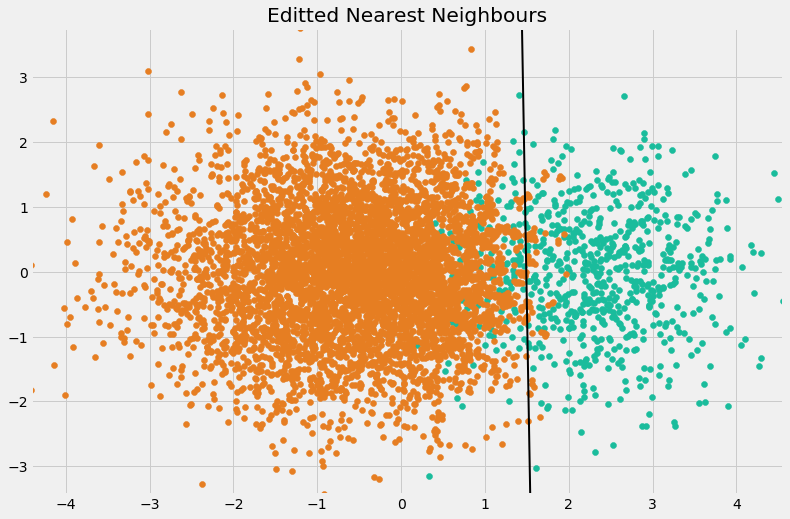

In [162]:
plt.scatter(list(zip(*X_1_res))[0], list(zip(*X_1_res))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2_res))[0], list(zip(*X_2_res))[1], color='#e67e22')

x_coords = list(zip(*X_1_res))[0] + list(zip(*X_2_res))[0]
y_coords = list(zip(*X_1_res))[1] + list(zip(*X_2_res))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("Editted Nearest Neighbours")
plt.plot(x1, x2, color='black', linewidth=2)
plt.show()

In [163]:
print (classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           L       0.98      0.92      0.95      2706
           S       0.53      0.83      0.64       294

   micro avg       0.91      0.91      0.91      3000
   macro avg       0.75      0.87      0.80      3000
weighted avg       0.94      0.91      0.92      3000



In [164]:
# Repeated Edited Nearest Neighbor
us = RepeatedEditedNearestNeighbours(n_neighbors=5, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))
clf_base = LogisticRegression()
grid = {'penalty': ['l1', 'l2']}
cv = KFold(X_train_res.shape[0], shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
clf.fit(X_train_res, y_train_res)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]
X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6294, 'S': 706})
Distribution of class labels after resampling Counter({'L': 5263, 'S': 706})


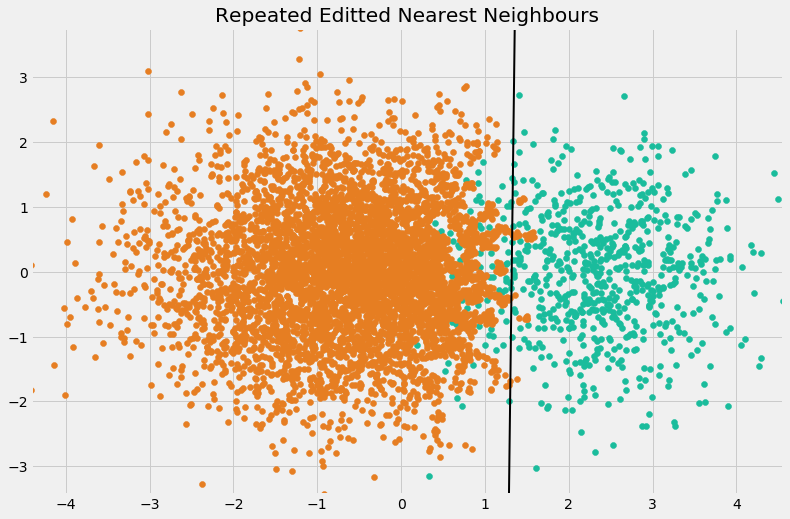

In [165]:
plt.scatter(list(zip(*X_1_res))[0], list(zip(*X_1_res))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2_res))[0], list(zip(*X_2_res))[1], color='#e67e22')

x_coords = list(zip(*X_1_res))[0] + list(zip(*X_2_res))[0]
y_coords = list(zip(*X_1_res))[1] + list(zip(*X_2_res))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("Repeated Editted Nearest Neighbours")
plt.plot(x1, x2, color='black', linewidth=2)
plt.show()

In [166]:
print (classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           L       0.99      0.90      0.94      2706
           S       0.48      0.88      0.62       294

   micro avg       0.89      0.89      0.89      3000
   macro avg       0.73      0.89      0.78      3000
weighted avg       0.94      0.89      0.91      3000



In [74]:
# Tomek link removal
us = TomekLinks(random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))
clf_base = LogisticRegression()
grid = {'penalty': ['l1', 'l2']}
cv = KFold(X_train_res.shape[0], shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
clf.fit(X_train_res, y_train_res)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]
X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 5981, 'S': 679})


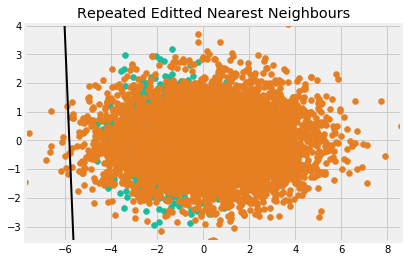

In [75]:
plt.scatter(list(zip(*X_1_res))[0], list(zip(*X_1_res))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2_res))[0], list(zip(*X_2_res))[1], color='#e67e22')

x_coords = list(zip(*X_1_res))[0] + list(zip(*X_2_res))[0]
y_coords = list(zip(*X_1_res))[1] + list(zip(*X_2_res))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("Tomek")
plt.plot(x1, x2, color='black', linewidth=2)
plt.show()

In [76]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           L       0.89      1.00      0.94      2679
           S       0.00      0.00      0.00       321

   micro avg       0.89      0.89      0.89      3000
   macro avg       0.45      0.50      0.47      3000
weighted avg       0.80      0.89      0.84      3000



In [77]:
# Random oversampling of minority class
os = RandomOverSampler(ratio=0.5, random_state=1)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)
print("Distribution of class labels before resampling {}".format(Counter(y_train)))
print("Distribution of class labels after resampling {}".format(Counter(y_train_res)))
clf_base = LogisticRegression()
grid = {'penalty': ['l1', 'l2']}
cv = KFold(X_train_res.shape[0], shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
clf.fit(X_train_res, y_train_res)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]
X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 6321, 'S': 3160})


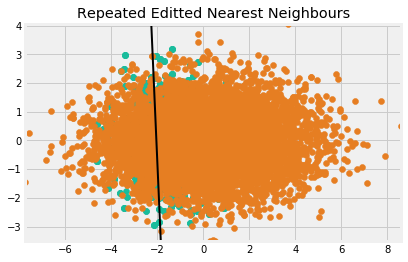

In [78]:
plt.scatter(list(zip(*X_1_res))[0], list(zip(*X_1_res))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2_res))[0], list(zip(*X_2_res))[1], color='#e67e22')

x_coords = list(zip(*X_1_res))[0] + list(zip(*X_2_res))[0]
y_coords = list(zip(*X_1_res))[1] + list(zip(*X_2_res))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("Random Over Samling")
plt.plot(x1, x2, color='black', linewidth=2)
plt.show()

In [79]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           L       0.91      0.84      0.87      2679
           S       0.17      0.28      0.21       321

   micro avg       0.78      0.78      0.78      3000
   macro avg       0.54      0.56      0.54      3000
weighted avg       0.83      0.78      0.80      3000



In [167]:
# Synthetic Minority Oversampling Technique (SMOTE)
os = SMOTE(ratio=0.5, k_neighbors=5, random_state=1)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)
print("Distribution of class labels before resampling {}".format(Counter(y_train)))
print("Distribution of class labels after resampling {}".format(Counter(y_train_res)))
clf_base = LogisticRegression()
grid = {'penalty': ['l1', 'l2']}
cv = KFold(X_train_res.shape[0],shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
clf.fit(X_train_res, y_train_res)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]
X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6294, 'S': 706})
Distribution of class labels after resampling Counter({'L': 6294, 'S': 3147})


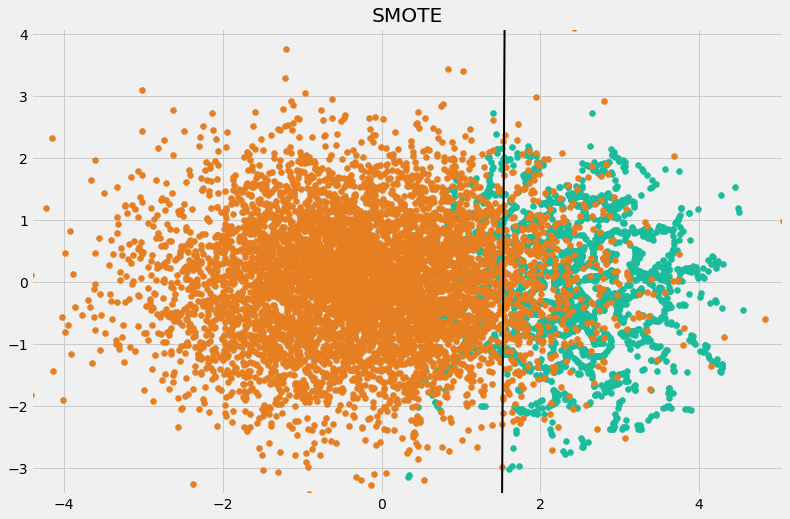

In [168]:
plt.scatter(list(zip(*X_1_res))[0], list(zip(*X_1_res))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2_res))[0], list(zip(*X_2_res))[1], color='#e67e22')

x_coords = list(zip(*X_1_res))[0] + list(zip(*X_2_res))[0]
y_coords = list(zip(*X_1_res))[1] + list(zip(*X_2_res))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("SMOTE")
plt.plot(x1, x2, color='black', linewidth=2)
plt.show()

In [169]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           L       0.98      0.92      0.95      2706
           S       0.54      0.82      0.65       294

   micro avg       0.91      0.91      0.91      3000
   macro avg       0.76      0.87      0.80      3000
weighted avg       0.94      0.91      0.92      3000



In [170]:
os_us = SMOTETomek(ratio=0.5,random_state=1)
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)
print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))
clf_base = LogisticRegression()
grid = {'penalty': ['l1', 'l2']}
cv = KFold(X_train_res.shape[0], shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
clf.fit(X_train_res, y_train_res)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]
X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6294, 'S': 706})
Distribution of class labels after resampling Counter({'L': 6089, 'S': 2942})


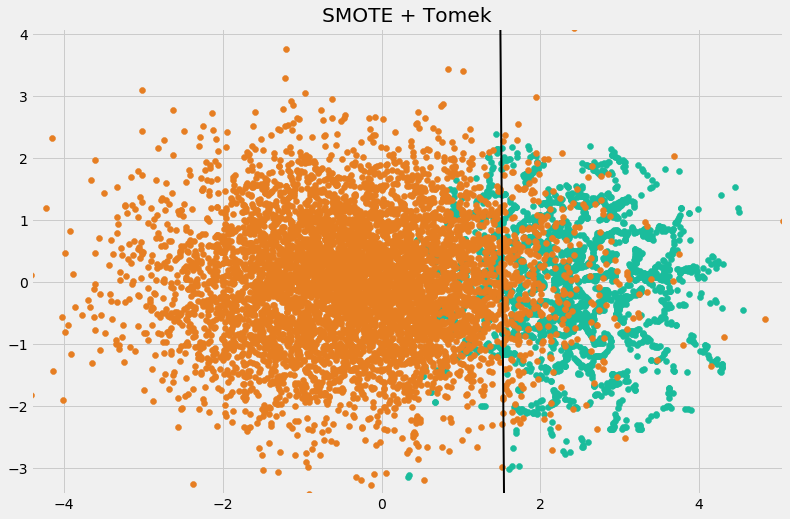

In [171]:
plt.scatter(list(zip(*X_1_res))[0], list(zip(*X_1_res))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2_res))[0], list(zip(*X_2_res))[1], color='#e67e22')

x_coords = list(zip(*X_1_res))[0] + list(zip(*X_2_res))[0]
y_coords = list(zip(*X_1_res))[1] + list(zip(*X_2_res))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("SMOTE + Tomek")
plt.plot(x1, x2, color='black', linewidth=2)
plt.show()

In [172]:
print (classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           L       0.98      0.92      0.95      2706
           S       0.54      0.82      0.65       294

   micro avg       0.91      0.91      0.91      3000
   macro avg       0.76      0.87      0.80      3000
weighted avg       0.94      0.91      0.92      3000



In [173]:
# SMOTE + ENN
os_us = SMOTEENN(ratio=0.6,random_state=1)
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)
print("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))
clf_base = LogisticRegression(class_weight='balanced')
grid = {'penalty': ['l1', 'l2']}
cv = KFold(X_train_res.shape[0], shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
clf.fit(X_train_res, y_train_res)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]
X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6294, 'S': 706})
Distribution of class labels after resampling Counter({'L': 5403, 'S': 2910})


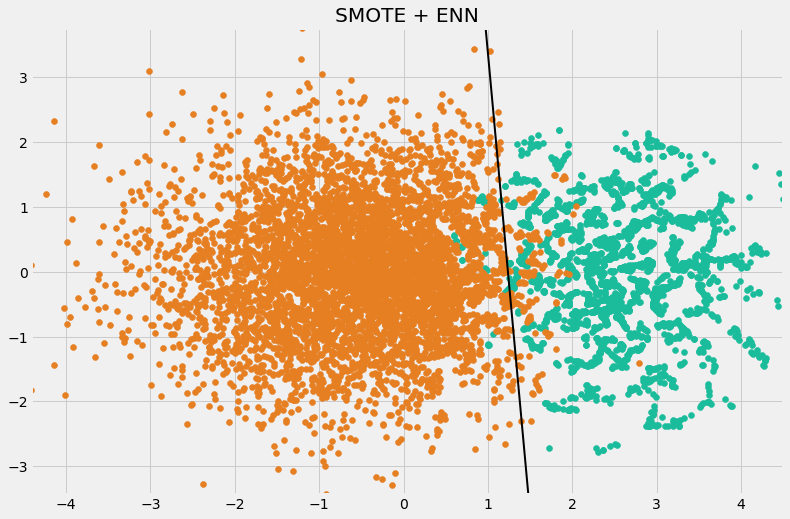

In [174]:
plt.scatter(list(zip(*X_1_res))[0], list(zip(*X_1_res))[1], color='#1abc9c')
plt.scatter(list(zip(*X_2_res))[0], list(zip(*X_2_res))[1], color='#e67e22')

x_coords = list(zip(*X_1_res))[0] + list(zip(*X_2_res))[0]
y_coords = list(zip(*X_1_res))[1] + list(zip(*X_2_res))[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])
plt.title("SMOTE + ENN")
plt.plot(x1, x2, color='black', linewidth=2)
plt.show()

In [175]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           L       0.99      0.88      0.93      2706
           S       0.45      0.88      0.60       294

   micro avg       0.88      0.88      0.88      3000
   macro avg       0.72      0.88      0.76      3000
weighted avg       0.93      0.88      0.90      3000



In [176]:
ens = EasyEnsemble()
X_train_res, y_train_res = ens.fit_sample(X_train, y_train)
y_pred_proba = np.zeros(len(y_test))
for idx in range(len(y_train_res)):
    clf_base = AdaBoostClassifier()
    grid = {'n_estimators': [100]}
    cv = KFold(X_train_res.shape[0], shuffle=True, random_state=0)
    clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
    clf.fit(X_train_res[idx], y_train_res[idx])
    y_pred_proba += list(zip(*clf.predict_proba(X_test)))[0]
y_pred_proba = y_pred_proba/len(y_train_res)
y_pred = (y_pred_proba > 0.5).astype(int)
y_pred = y_pred.astype('str')
y_pred[y_pred=='1'] ='L'
y_pred[y_pred=='0'] ='S'

In [177]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           L       0.99      0.87      0.93      2706
           S       0.43      0.89      0.58       294

   micro avg       0.88      0.88      0.88      3000
   macro avg       0.71      0.88      0.75      3000
weighted avg       0.93      0.88      0.89      3000

